This is lesson 4 of the 1st module, and I will be using the previous 3 lessons to put it all together and use it to figure out the assignment.

In [1]:
# as always, we have to import libraries and modules
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# set the font type and sizefor future figure use
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# set parameters for future use
g = 9.81 #gravity
vt = 4.9 # trim velocity
CD = 1.0 / 5.0 # drag coefficient
CL = 1.0 # lift coefficient

# set initial conditions for future use
v0 = 6.5 # start at the trim velocity
theta0 = -0.1 # trajectory angle
x0 = 0.0 # horizontal position
y0 = 2.0 # altitude

this next function will create the right hand side of the phugoid system of equations

In [4]:
def rhs_phugoid (u, CL, CD, g, vt):
    v, theta, x, y = u
    rhs = numpy.array([ -g * math.sin(theta) - CD / CL *g/vt**2 * v**2,
                      -g * math.cos(theta) / v + g / vt**2 * v,
                      v * math.cos(theta),
                      v* math.sin(theta)])
    return rhs

This next function returns the solution at the next time step using Euler's method

In [5]:
def euler_step(u, f, dt, *args):
    u_new = u + dt * f(u, *args)
    return u_new


this next function returns the difference in the L1-norm between the soluction on coarser grids to finer grids.

In [6]:
def l1_diff(u_coarse, u_fine, dt):
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

now we create the function that computes the next time step using the modified euler method of the equations above.

In [7]:
def rk2_step(u, f, dt, *args):
    u_start = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_start, *args)
    return u_new


now, like in lesson 3, we set ip arrays to save solutions, but now we are using both euler's and the RK method

In [8]:
T = 15.0 # total length of time
dt = 0.01 #time-step size
N= int(T / dt) + 1 # total number of time steps

# create arrays here
u_euler = numpy.empty((N, 4))
u_rk2 = numpy.empty((N, 4))

#set initial conditions to values above
u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0] = numpy.array([v0, theta0, x0, y0])

#time integration with both methods
for n in range(N-1):
    u_euler[n+1] = euler_step(u_euler[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_rk2[n + 1] = rk2_step(u_rk2[n], rhs_phugoid, dt, CL, CD, g, vt)
    


the next line gets the position of the glider with respect to time by finding the the correct array enterance values

In [9]:
x_euler = u_euler[:, 2]
y_euler = u_euler[:, 3]
x_rk2 = u_rk2[:, 2]
y_rk2 = u_rk2[:, 3]

the next line finds the first negative values of y_euler to see when the glider hits the ground

In [10]:
idx_negative_euler = numpy.where(y_euler < 0.0)[0]
if len(idx_negative_euler) == 0:
    idx_ground_euler = N - 1
    print('[Euler] Glider has not yet touched the ground.')
else:
    idx_ground_euler = idx_negative_euler[0]
    

the next line finds the first negative element of y_rk2

In [11]:
idx_negative_rk2 = numpy.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N - 1
    print('[RK2] Glider has not yet touched the ground.')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

now we can check to see if these two different methods produce the same solution

In [12]:
print('are the x-values close? {}'.format(numpy.allclose(x_euler, x_rk2)))
print('are the y_values close? {}'.format(numpy.allclose(y_euler, y_rk2)))

are the x-values close? False
are the y_values close? False


since they do differ, we can take a look visually and see if there is a physical representation of the error between the two methods

Distance traveled: 14.516


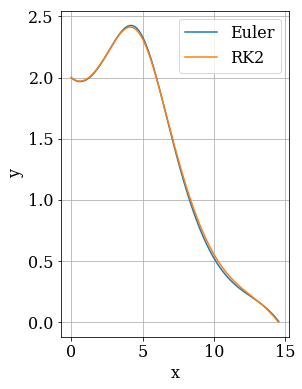

In [13]:
print('Distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

# plot the glider's path for both schemes
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
           label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
           label='RK2')
pyplot.legend();

now, in order to further see this difference, we can zoom in to further identify the difference between these solutions

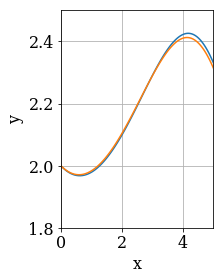

In [14]:
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler, y_euler, label='Euler')
pyplot.plot(x_rk2, y_rk2, label='RK2')
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

now we use lesson 3, grid convergence, with rk2 to see if we see the actual rate of convergence

In [15]:
#set the list of time-step sizes to investigate
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

#create a list to store solutions for each step size
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1 #number of time steps
    #set initial conditions to conditions set above
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    # time integration using rk2
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
        u_values.append(u)

now we find the difference between x points on all grids

In [16]:
diff_values =[]
for u, dt in zip(u_values, dt_values):
    diff = l1_diff(u[:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

now we can create a plot to find l1 norm difference!

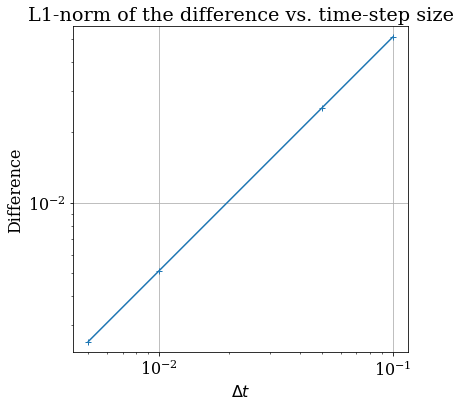

In [17]:
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm of the difference vs. time-step size')
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Difference')
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values[:-1],
             color='C0', linestyle='-', marker='+')
pyplot.axis('equal');

now, we can observe the order of convergence to figure out how well our model is working

In [18]:
r = 2 # time step refinement ratio
h = 0.001 # finest time-step

dt_values = [h, r*h, r**2 *h]
u_values =[]

for dt in dt_values:
    N = int(T / dt) + 1 #number of time steps
    #set initial conditions to parameters above
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)
    
p = (math.log(l1_diff(u_values[2], u_values[1], dt_values[2]) /
            l1_diff(u_values[1], u_values[0], dt_values[1])) /
    math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))
    

Observed order of convergence: p = 1.996


LEAPFROG METHOD

In [19]:
def leapfrog_step(u_prev, u, f, dt, *args):
    u_new = u_prev + 2.0 * dt * f(u, *args)
    return u_new

in order to start the leapfrog method, we must use another method since at the beginning of the method tracking, there is no n-1 value

In [20]:
# set parameters
g = 9.81 # gravity
vt = 4.9 #trim velocity
CD = 1.0 / 5.0 #drag coefficient
CL = 1.0 #lift coefficient

#set initial conditions
v0 = 6.5
theta0 = -0.1
x0 = 0.0 # horizontal position
y0 = 2.0 #altitude

T = 15.0 # total time
dt = 0.01 # time-step size
N = int(T / dt) + 1 #number of time steps

#create arrays to store solution
u_leapfrog = numpy.empty((N, 4))
#initial conditions to values above
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])
# use the RK2 method for first time step
u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

now we can create the time integration using the leapfrog method

In [21]:
for n in range(1, N - 1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n-1], u_leapfrog[n],
                                     rhs_phugoid, dt, CL, CD, g, vt)

now we can get the glider's position over time to create our plot

In [22]:
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

# find where the glider hits the ground using the index
idx_negative_leapfrog = numpy.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog)==0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has yet to touch the ground.')
else:
        idx_ground_leapfrog = idx_negative_leapfrog[0]

now we can find how far the glider traveled according to the leapfrog method

In [23]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))



Distance traveled: 14.516


now we can plot the glider's path using the leapfrog method

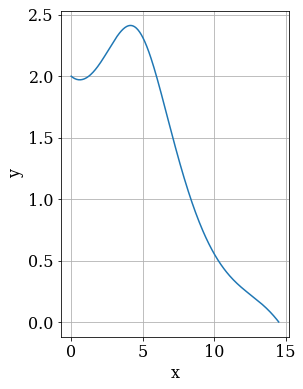

In [24]:
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog],
           y_leapfrog[:idx_ground_leapfrog])



now we can find the order of convergence using the methods we used above


In [50]:
r = 2 #time-step refinement ratio
h = 0.001 # finest time-step size

dt_values = [h, r*h, r**2 *h]
u_values =[]

for dt in dt_values:
    N = int(T/dt) + 1
    # set initial conditions to items above
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    u_values.append(u)

now we can compute order of convergence

In [53]:
'''
#print(l1_diff(u_values[1][:, 2]))

#print(l1_diff(u_values[2][:, 2]))
'''

p = (math.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                     dt_values[2]) /
             l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                     dt_values[1])) /
    math.log(r))
    

print('Observed order of convergence: p = {:.3f}'.format(p))

0.00016368762303506953
3.594457669424675e-05
Observed order of convergence: p = 2.187
